# 105.3. Forced photometry

<div style="max-width:300px; float: left; margin-right: 1em">

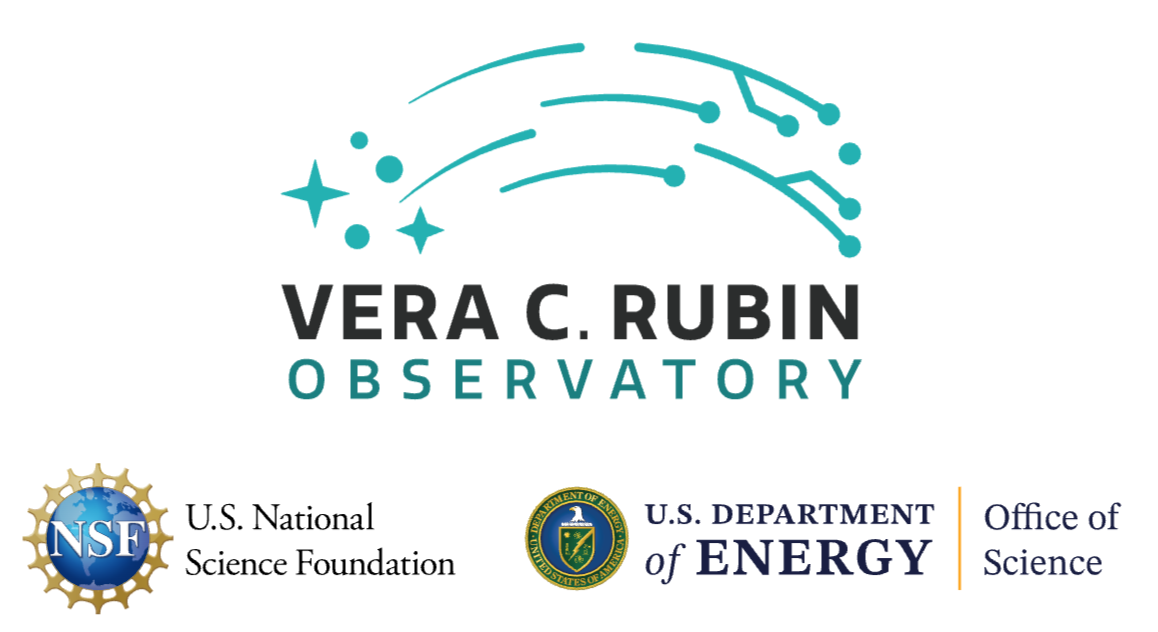

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-12-10 <br>
Repository: [github.com/lsst/tutorial-notebooks](https://github.com/lsst/tutorial-notebooks)\
DOI: [10.11578/rubin/dc.20250909.20](https://doi.org/10.11578/rubin/dc.20250909.20)

**Learning objective:** Make forced measurements on an image for a set of coordinates.

**LSST data products:** `deep_coadd`, `object` table

**Packages:** `lsst.pipe.tasks`, `lsst.daf.butler`

**Credit:**
Originally developed by the Rubin Community Science team working with Erfan Nourbakhsh.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the [Support Category](https://community.lsst.org/c/support) of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

In general, "forced" photometry refers to a measurement made at a fixed coordinate in an image, regardless of whether an above-threshold region was detected in that particular image.

This notebook performs forced photometry using the Data Preview 1 (DP1) data products on an input image, given a set of input coordinates (RA/Dec).

The `ForcedMeasurementDriverTask` serves as a convenience function, allowing users to measure sources without running a full-scale `pipetask` command or dealing with additional pipeline setup.
This task can measure fluxes, shapes, and other properties at known source positions (e.g., from a pre-existing catalog) on a given image, without running source detection.
For brevity, shape measurement is disabled in this tutorial.

**Related tutorials:** The 100-level tutorial on how to detect and measure sources.

### 1.1. Import packages

Import standard python packages `numpy`, `matplotlib`, and `astropy`.

From the `lsst` package, import the TAP service (`get_tap_service`) and the `Butler` for data access, `afw_display` to view images, and `ForcedMeasurementDriverConfig` and `ForcedMeasurementDriverTask`: mid-level configuration and task classes used to set up and execute forced photometry.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.io import ascii

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afw_display
from lsst.pipe.tasks.measurementDriver import (
    ForcedMeasurementDriverConfig,
    ForcedMeasurementDriverTask,
)

### 1.2. Define parameters and functions

Create an instance of the butler, and assert that it exists.

In [ ]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

Instantiate the TAP service and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Create a function called `fix_flux_columns` to rename output columns from the forced measurement task that are incorrectly labeled as instrument fluxes, when they are in fact not instrumental (i.e., in units of counts) but are calibrated fluxes in units of nJy.
This mistake will be fixed in future versions of the LSST Science Pipelines.

In [ ]:
def fix_flux_columns(table):
    """Rename the columns in an output table from the ForcedMeasurementDriverTask.

    This task is necessary to rename "instFlux" columns to "flux" and units from
    "ct" to "nJy".

    Parameters
    ----------
    table : Astropy Table
        An Astropy table resulting from executing the ForcedMeasurementDriver

    Outputs
    -------
    table : Astropy Table
        Transformed version of the input table, with columns and units updated.
    """

    cols_with_instflux = [col for col in np.array(table.colnames) if 'instFlux' in col]

    for col in cols_with_instflux:
        new_colname = str.replace(col, 'instFlux', 'flux')
        table.rename_column(col, new_colname)
        table[new_colname].unit = u.nJy

    return table

## 2. Measure objects in a deep coadd

### 2.1. Load an image and catalog

Identify coadded images overlapping a particular sky position and select one to run forced photometry on. Also load the corresponding `Object` table using the TAP service so that forced photometry can be run at the positions of already-detected objects.

Define the right ascension and declination as the center of the ECDFS field, and use the $r$ band.

In [ ]:
ra = 53.1
dec = -28.1
band = 'r'

Execute a butler query for deep coadd images.

In [ ]:
query = f"band='{band}' AND \
          patch.region OVERLAPS POINT({ra}, {dec})"
coadd_img_refs = butler.query_datasets('deep_coadd', where=query)

Assert that at least one matching image was returned, and retrieve the first in the list.

In [ ]:
assert len(coadd_img_refs) > 0
ref = coadd_img_refs[0]
deep_coadd = butler.get(ref)

Query for point-like objects from the `Object` table in a 0.3 degree radius near the position of interest that overlap the deep coadd image's tract and patch. 

In [ ]:
query = f"""SELECT TOP 50 objectId, coord_ra, coord_dec, {band}_psfMag, {band}_psfFlux
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
        CIRCLE('ICRS', {ra}, {dec}, 0.3)) = 1
        AND refExtendedness < 0.5
        AND {band}_psfMag < 26 AND {band}_psfMag > 17
        AND tract = {ref.dataId['tract']}
        AND patch = {ref.dataId['patch']}"""

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Retrieve the search results as `objtable`.
This table will be used both as an input list for forced measurement, and as a comparison for the results.

In [ ]:
assert job.phase == 'COMPLETED'
objtable = job.fetch_result().to_table()

Ensure that the table is not empty.

In [ ]:
assert len(objtable) > 0

Option to examine the `objtable`:

In [ ]:
# objtable

### 2.2. Run the forced measurement driver

Configure the forced measurement driver to use `base_PsfFlux` as the algorithm for the PSF flux slot, and `base_TransformedCentroidFromCoord` for centroids transformed from the reference catalog. Set other config parameters to disable shape measurement, avoid replacing other detected footprints with noise, and enable aperture correction for the selected flux slot. These are simply examples of how to set configuration options, and are not required to run the task.

**_Note:_** *`base_PsfFlux` and `base_TransformedCentroidFromCoord` are included by default in the measurement plugins, so there's no need to add them manually to `config.measurement.plugins.names`. They’ll be picked up automatically.*

In [ ]:
config = ForcedMeasurementDriverConfig()
config.measurement.slots.psfFlux = "base_PsfFlux"
config.measurement.slots.centroid = "base_TransformedCentroidFromCoord"
config.measurement.slots.shape = None
config.measurement.doReplaceWithNoise = False
config.doApCorr = True

Option: examine the configuration.

In [ ]:
# config

Create the forced photometry driver task using the configuration.

In [ ]:
driver = ForcedMeasurementDriverTask(config=config)

Run the task using the input table of source positions and IDs, the `deep_coadd` image, and required parameters: column names for ID, RA, and Dec, plus a PSF footprint scaling factor (used to create synthetic footprints since detection is skipped in forced photometry).

In [ ]:
result = driver.runFromAstropy(
    objtable,
    deep_coadd,
    id_column_name="objectId",
    ra_column_name="coord_ra",
    dec_column_name="coord_dec",
    psf_footprint_scaling=3.0,
)

Because the `ForcedMeasurementDriverTask` relies on code that is typically used in early stages of data processing, it assumes that fluxes are instrumental fluxes and appends the suffixes `_instFlux` and `_instFluxErr` to the output columns.
It also sets the units for these columns to "ct" (counts).

However, these assumptions about the types of fluxes are incorrect when running this task on calibrated visit and deep coadd images, whose pixel values are in nJy.

Confirm that the pixel values are in units of nJy.

In [ ]:
deep_coadd.metadata['BUNIT']

Use the function defined in Section 1.2 to fix the column names.
This step is temporary as the column names will be fixed in the future.

In [ ]:
result = fix_flux_columns(result)

Examine the resulting Astropy table containing the measured sources. Each row corresponds to a record from the input table, with columns for source ID, RA, and Dec, along with additional measurement fields defined by the configuration.

In [ ]:
result[:5]

The table now includes PSF fluxes (`base_psfFlux_flux`) and aperture fluxes (e.g., `base_CircularApertureFlux_3_0_flux` for a 3-pixel aperture), among many other columns.

Most of the output columns are similar to columns that exist in the `Source` table -- refer to the [schema for the DP1 Source table](https://sdm-schemas.lsst.io/dp1.html#Source) and the 200-level tutorial notebook on the `Source` catalog for descriptions.

Each flux measurement has an associated flux error and one or more flag columns to allow filtering of bad measurements. Additionally, there are many pixel-based flags (denoted `base_PixelFlags_*`) highlighting possible issues with the data for each source.

Columns that begin with `slot_` are duplicates of other columns in the table.
These exist as a way of telling algorithms in the Science Pipelines which is the "preferred" measurement for things like positions, shapes, and fluxes.
Because there are multiple ways of measuring shapes (for example), this lets processing algorithms know which of these to select.
Note that the specific measurements populating (some of) the slots were configured above, for example `config.measurement.slots.psfFlux = "base_PsfFlux"` was specified. 

The forced measurement functionality is limited to a handful of measurement plugins (for example, model-fitting algorithms will not work with this task because they require more ancillary information than it is set up to receive). Nonetheless, it offers a quick and easy way to extract measurements at arbitrary positions.

### 2.3. Compare forced measurements to the Object table

Make a plot showing the ratio of the measured PSF fluxes from the forced measurement task to the `psfFlux` for the same objects in the `Object` table. Plot these as a function of magnitude, using Astropy units to convert `slot_PsfFlux_flux` from the `result` table to AB magnitudes.

In [ ]:
meas_mag = (result['slot_PsfFlux_flux'].value*u.nJy).to(u.ABmag)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(meas_mag, result['slot_PsfFlux_flux']/objtable['r_psfFlux'],
        'o', alpha=0.5, mew=1, mec='black', color='black')
ax.hlines(1.0, 17.3, 26.3, linestyle=':', color='gray')
ax.set_xlim(17.3, 26.3)
ax.set_xlabel('force-measured PSF magnitude')
ax.set_ylabel('flux ratio (forced / Object)')
plt.show()

> **Figure 1:** The flux ratio of the force-measured PSF flux divided by the PSF flux from the `Object` table, vs. the force-measured PSF magnitude (all for $r$-band).

The plot above demonstrates that the **forced fluxes can sometimes be higher (brighter) than fluxes in the `Object` table**.
This is usually **due to contaminating flux** from nearby objects, as deblending is not performed as part of forced measurement, but it is performed when the fluxes in the `Object` table are derived.

Delete the image and catalogs from memory.

In [ ]:
del deep_coadd, objtable, result

## 3. Measure sources in a visit image

### 3.1. Load an image and catalog

The forced measurement task can be run on any `ExposureF` object. To demonstrate this, retrieve a `visit_image` and execute the driver to extract forced photometry on that image. The appropriate input catalog for `visit_image` measurements is the `Source` table.

Query the butler for overlapping visit images and retrieve the first in the list.

In [ ]:
query = f"band='{band}' AND \
          visit.region OVERLAPS POINT({ra}, {dec})"
visit_img_refs = butler.query_datasets('visit_image', where=query)
assert len(visit_img_refs) > 0
ref = visit_img_refs[0]
visit_image = butler.get(ref)

Query the TAP service for point-like sources detected in the visit image.

In [ ]:
query = f"""SELECT TOP 50 sourceId, ra, dec, psfFlux
        FROM dp1.Source
        WHERE CONTAINS(POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra}, {dec}, 0.3)) = 1
        AND extendedness < 0.5
        AND visit = {ref.dataId['visit']}
        AND detector = {ref.dataId['detector']}"""

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
srctable = job.fetch_result().to_table()
assert len(srctable) > 0

### 3.2. Run the forced measurement driver

Configure and run forced photometry.

In [ ]:
config = ForcedMeasurementDriverConfig()
config.measurement.slots.psfFlux = "base_PsfFlux"
config.measurement.slots.centroid = "base_TransformedCentroidFromCoord"
config.measurement.slots.shape = None
config.measurement.doReplaceWithNoise = False
config.doApCorr = True

In [ ]:
driver = ForcedMeasurementDriverTask(config=config)

In [ ]:
src_result = driver.runFromAstropy(
    srctable,
    visit_image,
    id_column_name="sourceId",
    ra_column_name="ra",
    dec_column_name="dec",
    psf_footprint_scaling=3.0,
)

In [ ]:
src_result = fix_flux_columns(src_result)

In [ ]:
src_result[:5]

### 3.3. Compare forced measurements to the Source table

Make a plot showing the ratio of the measured PSF fluxes from the forced measurement task to the `psfFlux` for the same objects in the `Source` table. Plot these as a function of magnitude, using Astropy units to convert `slot_PsfFlux_flux` from the `result` table to AB magnitudes.

In [ ]:
meas_mag = (src_result['slot_PsfFlux_flux'].value*u.nJy).to(u.ABmag)

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(meas_mag, src_result['slot_PsfFlux_flux']/srctable['psfFlux'],
         'o', alpha=0.5, mew=1, mec='black', color='black')
plt.hlines(1.0, 17.3, 26.3, linestyle=':', color='gray')
plt.xlim(17.3, 26.3)
plt.xlabel('force-measured PSF magnitude')
plt.ylabel('flux ratio (forced / Source)')
plt.show()

> **Figure 2:** Similar to Figure 1, the flux ratio of the force-measured PSF flux divided by the PSF flux from the `Source` table, vs. the force-measured PSF magnitude (all for $r$-band).

As in Figure 1, force-measured fluxes can be higher than those in the `Source` table due to contaminating flux from nearby sources.

Delete the image and catalogs from memory.

In [ ]:
del visit_image, srctable, src_result

## 4. Measure subthreshold sources in a visit image

Often, the motivation for forced photometry is to make forced measurements at a set of coordinates where no object or source has been detected with SNR>5 (i.e., coordinates that are not in the `Object` or `Source` tables).

These coordinates might be for subthreshold detections (e.g., SNR < 5) or detections from other surveys (non-Rubin surveys, e.g., infrared, space-based).

In this example, the coordinates for a small set of subthreshold sources in a given visit image are loaded, and then forced PSF measurements are made.

### 4.1. Load an image and catalog

This example has been designed to work with the following visit image.

In [ ]:
visitId = 2024110800263
detectorId = 3
visit_image = butler.get('visit_image',
                         visit=visitId, detector=detectorId)

A subset of subthreshold sources with $4.0 < SNR < 4.5$ in a small region of the visit image have already been detected and stored in a file.

Load the file as an astropy table.

In [ ]:
filepath = '/rubin/cst_repos/tutorial-notebooks-data/data/'
filename = 'dp1_105_3_subthreshold.dat'
subthresh = ascii.read(filepath+filename)
print(subthresh.colnames)

Option to view the loaded table.

In [ ]:
# subthresh

### 4.2. Run the forced measurement driver

The configuration is the same as in Section 3.2.

In [ ]:
config = ForcedMeasurementDriverConfig()
config.measurement.slots.psfFlux = "base_PsfFlux"
config.measurement.slots.centroid = "base_TransformedCentroidFromCoord"
config.measurement.slots.shape = None
config.measurement.doReplaceWithNoise = False
config.doApCorr = True

In [ ]:
driver = ForcedMeasurementDriverTask(config=config)

Pass the table `subthresh` and the `visit_image`, and the appropriate column names.

In [ ]:
src_result = driver.runFromAstropy(
    subthresh,
    visit_image,
    id_column_name="id",
    ra_column_name="ra",
    dec_column_name="dec",
    psf_footprint_scaling=3.0,
)

Fix the column names.

In [ ]:
src_result = fix_flux_columns(src_result)

Assert that the input and output tables have the same length.

In [ ]:
assert len(subthresh) == len(src_result)
print(len(subthresh), len(src_result))

Option to display the first five lines of the output table.

In [ ]:
# src_result[:5]

### 4.3. Compare the forced measurements to the subthreshold detections

Convert fluxes to magnitudes.

In [ ]:
src_result['mag'] = (src_result['slot_PsfFlux_flux'].value*u.nJy).to(u.ABmag)

Plot the forced photometry magnitude vs. the detected subthreshold magnitudes.

In [ ]:
fig = plt.figure(figsize=(6, 4))
for i in range(len(subthresh)):
    color = 'darkorange'
    if np.abs(subthresh['rmag'][i] - src_result['mag'][i] > 0.02):
        color = 'dodgerblue'
    plt.plot(subthresh['rmag'][i], src_result['mag'][i],
             'o', alpha=0.7, mew=1, mec='grey', color=color)
plt.xlabel('detected subthreshold magnitude')
plt.ylabel('forced photometry magnitude')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

> **Figure 3:** The forced photometry magnitude versus the detected subthreshold magnitude from the input file. Sources for which the forced photometry differs by more than (an arbitrary) 0.02 magnitudes from the input photometry are colored blue, and the rest colored orange.

### 4.4. Mark the subthreshold sources on the image

Open the Firefly display tab and set the display to frame 1.

In [ ]:
afw_display.setDefaultBackend('firefly')
display = afw_display.Display(frame=1)

Display the visit image in the Firefly tab, and reset the mask to be 100% transparent (i.e., show pixel fluxes only, not the mask plane).

In [ ]:
display.image(visit_image)
display.setMaskTransparency(100)

Plot circular markers at the location of all subthreshold sources, with the same marker color convention (blue vs. orange) as in Figure 3.

In [ ]:
with display.Buffering():
    for i in range(len(subthresh)):
        color = 'orange'
        if np.abs(subthresh['rmag'][i] - src_result['mag'][i] > 0.02):
            color = 'cyan'
        x = src_result['slot_Centroid_x'][i]
        y = src_result['slot_Centroid_y'][i]
        display.dot('o', x, y, size=10, ctype=color)
        del x, y

Zoom in on the marked sources in the Firefly tab.
Notice that some of the blue (cyan) sources -- which had force-measured magnitudes brighter than their detection magnitudes -- might have some flux contributed from un-deblended nearby objects (such as bright star diffraction spikes).

<div style="max-width:300px; float: left; margin-right: 1em">

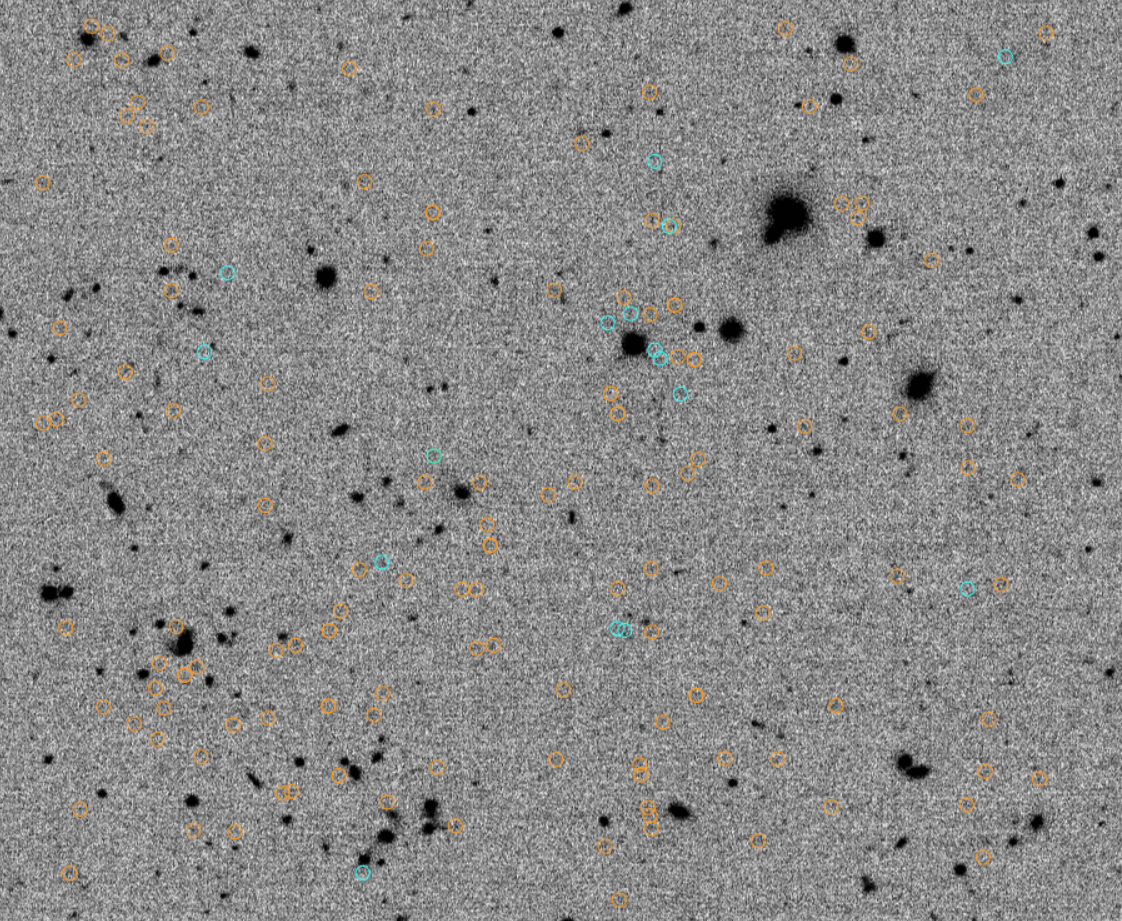

</div>

> **Figure 4:** A screenshot of what the Firefly window should display: subthreshold sources for which forced photometry was done, marked with orange markers, or cyan if the difference between original detection magnitude and forced photometry magnitude was greater than 0.02 mag (an arbitrary boundary for illustrative purposes).

If desired, erase all markers.

In [ ]:
# display.erase()